# Carvana image masking

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
path = Path('/home/jupyter/my-datasets/carvana-image-masking-challenge/')

In [3]:
path.ls()

[PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/29bb3ece3180_11.jpg'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks.csv'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/test_hq'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/sample_submission.csv'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/metadata.csv'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/test'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_hq')]

Let's look at some images

In [4]:
fnames = get_image_files(path/'train')

In [5]:
fnames[:3]

[PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train/31186febd775_10.jpg'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train/4b74275babf7_06.jpg'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train/7251c8797749_14.jpg')]

In [6]:
mask_names = get_image_files(path/'train_masks')

In [7]:
mask_names[:3]

[PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks/419687d50dcd_09_mask.gif'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks/a4551c5409e3_13_mask.gif'),
 PosixPath('/home/jupyter/my-datasets/carvana-image-masking-challenge/train_masks/04bd942b463b_16_mask.gif')]

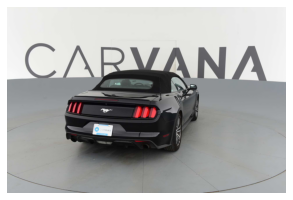

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
img.shape

torch.Size([3, 1280, 1918])

In [10]:
def get_mask_from_path(x): return Path(str(x.parent)+'_masks')/(x.name.split('.')[0]+'_mask.gif')

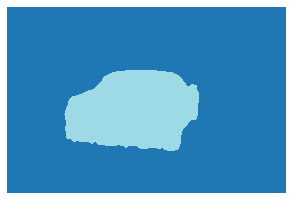

In [11]:
mask = open_mask(get_mask_from_path(img_f), div=True)
mask.show(figsize=(5,5), alpha=1)

In [12]:
mask.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [13]:
mask.data.unique()

tensor([0, 1])

So the masks are in `[0, 255]`. Probably want to transform the images to divide by 255.

## Make a validation set

Each car has exactly 16 images, each one taken at different angles. Each car has a unique id and images are named according to id_01.jpg, id_02.jpg ... id_16.jpg.

In [14]:
import random

In [15]:
train_images = (path/'train').ls()

In [16]:
img_ids = set()
for img_path in train_images:
    img_id = str(img_path.name).split('_')[0]
    if img_id != 'models':
        img_ids.add(img_id)

In [17]:
len(img_ids)

318

In [18]:
318*16 == len(train_images)

False

So there are 318 cars in total, and each car has 16 images

In [19]:
VAL_FRAC = 0.2

Randomly shuffle the car ids. **NOTE: Restarting the kernel results in a different validation set! I should write the validation list to file in future?**

In [20]:
seed = 42
np.random.seed(seed)
img_ids_list = np.array(list(img_ids))
np.random.shuffle(img_ids_list)

Split the car IDs into a validation set

In [21]:
validation_ids = img_ids_list[:int(len(img_ids)*0.2)]
train_ids = img_ids_list[int(len(img_ids)*0.2):]

In [22]:
len(validation_ids) + len(train_ids)

318

Get all images associated with the validation set

In [23]:
validation_ids = set(validation_ids)

In [24]:
valid_names = []
for img_path in train_images:
    img_id = str(img_path.name).split('_')[0]
    if img_id in validation_ids:
        valid_names.append(img_path.name)

In [25]:
len(valid_names)

1008

## Build a databunch

In [26]:
bs = 16

In [27]:
codes = ['bg','car']

See here for how to open masks with `div=True` https://forums.fast.ai/t/unet-binary-segmentation/29833/48 (though this doesn't seem very stable as `fastai` is in development, so no guarantees it'll work forever).

In [28]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [29]:
src = (SegItemListCustom.from_folder(path/'train')
                           .split_by_files(valid_names)
                           .label_from_func(get_mask_from_path, classes=codes)
      )

Let's use smaller images for training speed, and also because it works well to gradually increase image size.

In [61]:
data = (src.transform(get_transforms(), tfm_y=True, size=224)
           .databunch(bs=bs)
           .normalize(imagenet_stats)
       )

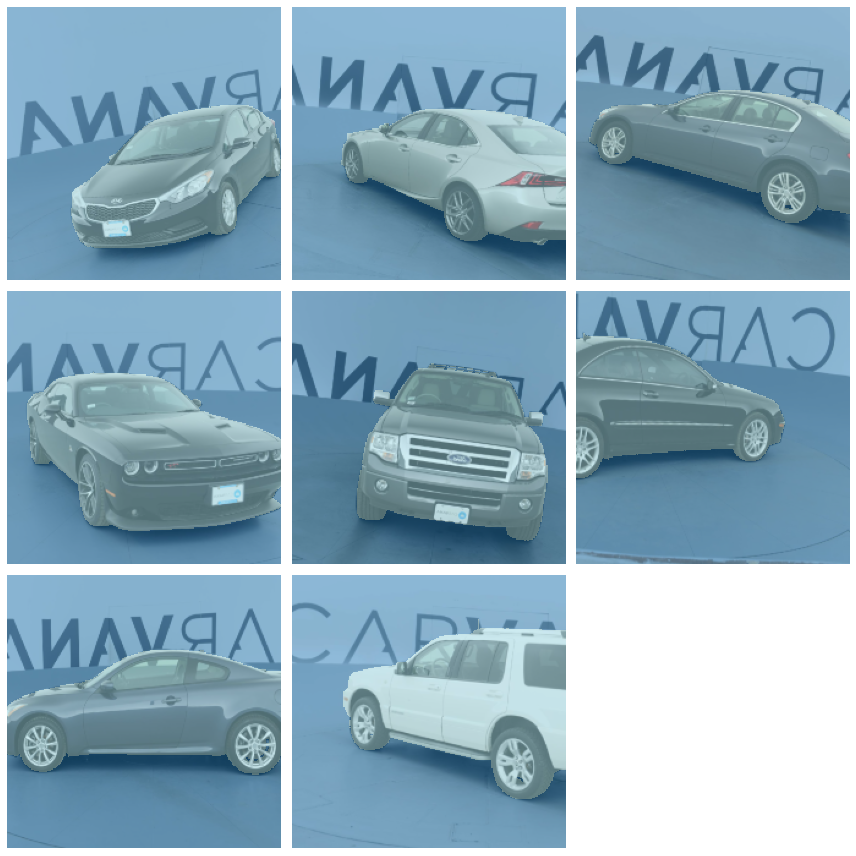

In [40]:
data.show_batch(3)

Check to see whether the hack to cast open images with `div=True` worked

In [46]:
x, y = data.one_batch()

In [52]:
x[0,...].min(), x[0,...].max()

(tensor(0.0237), tensor(1.0000))

In [51]:
y[0,...].min(), y[0,...].max()

(tensor(0), tensor(1))

Fab.

## Build U-net

This competition uses the [dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) as the loss. 

In [54]:
wd = 1e-2  # weight decay (L2 regularization)

In [62]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd, bottle=True)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


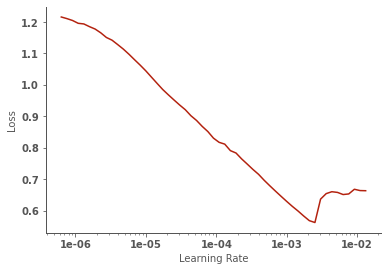

In [63]:
lr_find(learn)
learn.recorder.plot()

In [68]:
lr = 2e-4

Target: 0.99666 on the dice coefficient to be in top 10% of the contest. 0.99733 is the top score.

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.037356,0.036472,0.974478,01:43
1,0.027257,0.024825,0.982814,01:42
2,0.020898,0.023150,0.983748,01:42
3,0.017071,0.015350,0.989408,01:40
4,0.014852,0.012785,0.991162,01:40
5,0.013248,0.011758,0.991824,01:40
6,0.017456,0.012114,0.991668,01:40


Ooops computer died. Where were we...

In [71]:
learn.save('stage-1')

In [72]:
learn.fit_one_cycle(2, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.009633,0.009833,0.993133,01:39
1,0.009655,0.009020,0.993652,01:39


In [74]:
learn.save('stage-1b')

In [75]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.008970,0.008889,0.993725,01:41
1,0.009213,0.008957,0.993725,01:39
2,0.008516,0.008342,0.994124,01:40


In [76]:
learn.save('stage-1c')

In [80]:
learn.unfreeze()

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


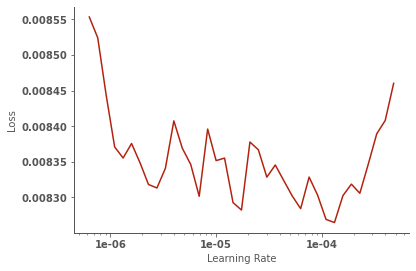

In [81]:
lr_find(learn)
learn.recorder.plot()

In [82]:
learn.fit_one_cycle(4, slice(1e-5, lr/10), pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.008169,0.008315,0.994146,01:41
1,0.008275,0.008312,0.994141,01:41
2,0.007978,0.008261,0.994192,01:41
3,0.008047,0.008229,0.994211,01:40


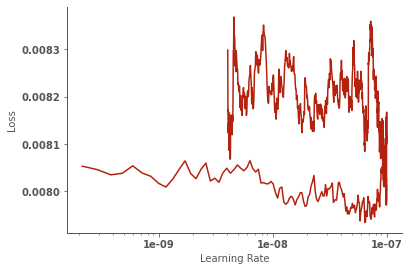

In [83]:
learn.recorder.plot()

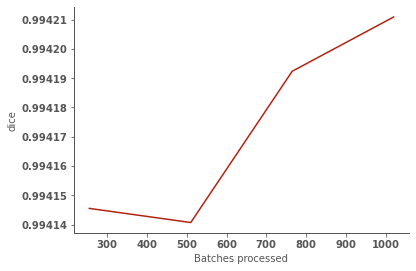

In [84]:
learn.recorder.plot_metrics()

In [85]:
learn.save('stage-2')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


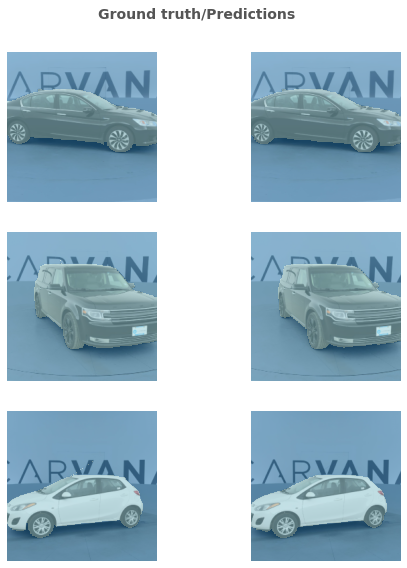

In [89]:
learn.show_results(rows=3, figsize=(8,9))

Results look great!

But in terms of getting those final few hundredths of a percent in the dice score, it looks like this approach has out of steam. Let's look at full-size images now, to see if we can get in the top 10%!

In [88]:
img.shape[1:]

torch.Size([1280, 1918])

# Go big

Let's try and train on larger images to see whether allowing the model to see more detail will boost the dice score. It almost certainly should -- it's just a matter of whether I can persuade the `fastai` APIs to do it!!

In [31]:
bs = 4

In [32]:
wd = 1e-2

In [56]:
data = (src.transform(get_transforms(), tfm_y=True, size=img.shape[1]//2)
           .databunch(bs=bs)
           .normalize(imagenet_stats)
       )

In [57]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd, bottle=True)

In [58]:
learn.load('stage-2');

In [59]:
x,y = data.one_batch()

In [60]:
y.shape

torch.Size([1, 1, 640, 640])

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


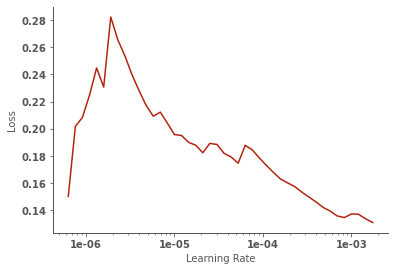

In [61]:
lr_find(learn)
learn.recorder.plot()

I'm a bit puzzled about why the loss is looking like this. Looks like it wants to entirely retrain the model. Let's just see what happens...

In [62]:
learn.unfreeze()

In [63]:
lrs = slice(1e-5, 1e-4)

In [64]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,dice,time
0,0.007922,0.007335,0.995148,13:11
1,0.006790,0.007262,0.995124,13:11
2,0.006312,0.006755,0.995443,13:11
3,0.006066,0.005886,0.995973,13:11
4,0.004685,0.005336,0.996317,13:11


Yes!! This is working!!!

_Caveat_ : I had to restart my kernel because the GPU ran out of memory, which meant that I am using a different validation set here compared to the above. In future I will save the validation filenames to a file, so these sorts of inferences make more sense. But the big jump in dice score makes me feel confident that something is working here -- it also makes intuitive sense.

_Bigger caveat:_ New validation set means that the model is now seeing more images, so I've lost some protection from overfitting!!

I think I'm going to stop here because I'm no longer confident in my dice scores. I'd just need to come back and fix up my validation set.